In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import csv

import scipy.optimize as op
import scipy.stats
from scipy.optimize import curve_fit
import scipy.io
from scipy.stats import rice

import random
import pickle
import seaborn as sns

import numpy as np
from scipy.stats import ttest_ind, ttest_ind_from_stats, wilcoxon,ttest_rel, pearsonr,shapiro,f_oneway, ranksums
from scipy.special import stdtr
import csv
import pandas as pd

from scipy.integrate import quad
import sys 
import os
#sys.path.append(os.path.abspath("/Users/neuroimaging/Desktop/MR-code/Python_Code"))

#from ML_UsefulFunctions import *
#from KidneyROIAnalyses import *

from scipy import special

from scipy.integrate import tplquad

pd.options.display.float_format = '{:.3f}'.format


from sklearn.feature_selection import SequentialFeatureSelector

import warnings
warnings.simplefilter("ignore")


from EllipsoidalSimulationCode import *

from sklearn.metrics import r2_score

from statistics import mean

pl.rcParams["font.family"] = "Times New Roman"

def func(x,m,b):
    return m*x + b

def biexp_func(b, frac_fast,frac_slow,diff_fast,diff_slow):
    Data = frac_slow*np.exp(-b*diff_slow)+frac_fast*np.exp(-b*diff_fast)
    normal = frac_slow+frac_fast
    return Data/normal

def monoexp_func(b, frac, diff):
    Data = frac*np.exp(-b*diff)
    return Data

In [2]:
fileloc = '/Users/miraliu/Desktop/PostDocCode/Multiexp_Simulations_python/MultiExpSimulatedCurves_20240611.xlsx'
df_True = pd.read_excel(fileloc,sheet_name = 'TrueData') 

df_TrueParams = pd.read_excel(fileloc,sheet_name = 'Parameters') 
df_AveragedNoise = pd.read_excel(fileloc,sheet_name = 'AveragedNoise') 
#Truth=Truth.rename(columns={c: 'True '+c for c in Truth.columns if c not in ['Run Number', 'Unnamed']})

b_values11 = np.array([0,10,30,50,80,120,200,400,800])#, 1100, 1380]) # medium range 11 b values 0 - 1380


In [3]:
# trying tri-exp fit to the df_True
TrueFracs = []
TrueDiffs = []
FitFracs = []
FitDiffs = []
for j in range(500):
    #popt, pcov = curve_fit(biexp_func, b_values11,df_AveragedNoise.iloc[j,2:-2],p0=[.1,.7, 0.1, 0.001],bounds=(0, [1,1,.1,.1]),maxfev=10000)
    
    ## order popt from fast to slow diffusion
    #norm_popt = popt[0]+popt[1]
    #idx_sort = popt[2:4].argsort()
    #fracs = popt[0:2]/norm_popt
    #diffusions = popt[2:4]
    #fracs=fracs[idx_sort[::-1]]
    #diffusions=diffusions[idx_sort[::-1]]
    #print(*[df_TrueParams['true fast fraction'].iloc[j],df_TrueParams['true med fraction'].iloc[j],df_TrueParams['true slow fraction'].iloc[j],df_TrueParams['true fast diffusion'].iloc[j],df_TrueParams['true med diffusion'].iloc[j],df_TrueParams['true slow diffusion'].iloc[j]])
    #popt, pcov = curve_fit(biexp_func, b_values11[6:],df_True.iloc[j,2:-2],p0=[.1,.7, 0.1, 0.001],bounds=(0, [1,1,.1,.1]),maxfev=10000)
    
    ## two step fit
    
    # fit slow
    popt1, pcov = curve_fit(monoexp_func, b_values11[6:],df_True.iloc[j,8:-2],p0=[.7, 0.001],bounds=(0, [1,.1]),maxfev=10000)

    #pl.plot(b_values11, monoexp_func(b_values11, popt1[0], popt1[1]))
    #pl.scatter(b_values11,df_True.iloc[j,2:-2])
    
    # subtract slow fit
    popt2, pcov = curve_fit(monoexp_func, b_values11,df_True.iloc[j,2:-2]-monoexp_func(b_values11,popt1[0], popt1[1]),p0=[.1, 0.01],bounds=(0, [1,.2]),maxfev=10000)

    
    ## order popt from fast to slow diffusion
    norm_popt = popt1[0]+popt2[0]
    diffusions = [popt1[1], popt2[1]]
    fracs=[popt1[0], popt2[0]]/norm_popt
    #print(*[df_TrueParams['true fast fraction'].iloc[j],df_TrueParams['true med fraction'].iloc[j],df_TrueParams['true slow fraction'].iloc[j],df_TrueParams['true fast diffusion'].iloc[j],df_TrueParams['true med diffusion'].iloc[j],df_TrueParams['true slow diffusion'].iloc[j]])
    
    #pl.plot(b_values11, biexp_func(b_values11, fracs[0], fracs[1], diffusions[0], diffusions[1]))
    #pl.scatter(b_values11,df_True.iloc[j,2:-2])
    ## order given true values from fast to slow just in case
    givenfracs = np.array([df_TrueParams['true fast fraction'].iloc[j],df_TrueParams['true med fraction'].iloc[j],df_TrueParams['true slow fraction'].iloc[j]])
    givendiffusions = np.array([df_TrueParams['true fast diffusion'].iloc[j],df_TrueParams['true med diffusion'].iloc[j],df_TrueParams['true slow diffusion'].iloc[j]])
    idx_sort = givendiffusions.argsort()
    givenfracs = givenfracs[idx_sort[::-1]]
    givendiffusions = givendiffusions[idx_sort[::-1]]

    TrueFracs.append(list(givenfracs))
    TrueDiffs.append(list(givendiffusions))
    FitFracs.append(list(fracs))
    FitDiffs.append(list(diffusions))
    

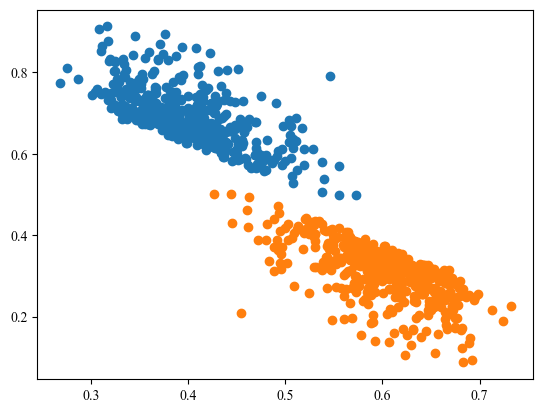

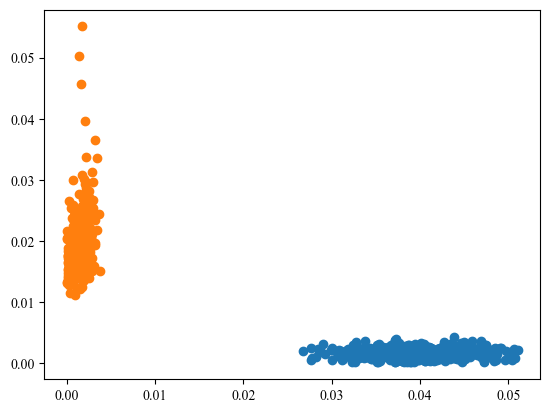

In [4]:

pl.scatter((np.array(TrueFracs)[:,0]+np.array(TrueFracs)[:,1]),np.array(FitFracs)[:,0],label= 'fast frac')

#pl.scatter(np.array(TrueFracs)[:,1],np.array(FitFracs)[:,1], label = 'med frac')
pl.scatter(np.array(TrueFracs)[:,2],np.array(FitFracs)[:,1], label = 'slow frac')
pl.show()

pl.scatter((np.array(TrueDiffs)[:,0]+np.array(TrueDiffs)[:,1])/2,np.array(FitDiffs)[:,0],label= 'fast diffs')
#pl.scatter(np.array(TrueDiffs)[:,1],np.array(FitDiffs)[:,1], label = 'med diffs')
pl.scatter(np.array(TrueDiffs)[:,2],np.array(FitDiffs)[:,1], label = 'slow diffs')
pl.show()




# combined fD isotropic no noise against average tubule + vascular

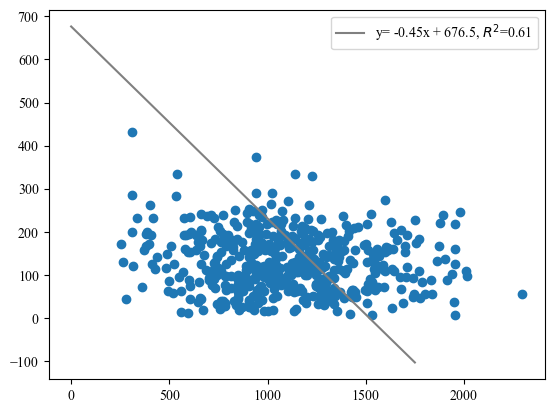

SignificanceResult(statistic=-0.7601460761460762, pvalue=4.398720720048972e-189)
All fD difference = -186.58181 ± 838.86787, -35.24087%
fast fD mean difference = -8.58780± 3.37164, -88.77486%
slow fD mean difference = 5.27079± 1.95027, 631.24636%


In [5]:
TruefastfDs= (1000*np.array(TrueFracs)[:,0]*np.array(TrueDiffs)[:,0] + 1000*np.array(TrueFracs)[:,1]*np.array(TrueDiffs)[:,1])
FitfastfDs = 1000*np.array(FitFracs)[:,0]*np.array(FitDiffs)[:,0]

#TruemedfDs= 1000*np.array(TrueFracs)[:,1]*np.array(TrueDiffs)[:,1]
#FitmedfDs = 1000*np.array(FitFracs)[:,1]*np.array(FitDiffs)[:,1]

TrueslowfDs= 1000*np.array(TrueFracs)[:,2]*np.array(TrueDiffs)[:,2]
FitslowfDs = 1000*np.array(FitFracs)[:,1]*np.array(FitDiffs)[:,1]

AllTrue = np.append(TruefastfDs,TrueslowfDs)
AllFit = np.append(FitfastfDs,FitslowfDs)

pl.scatter(112.5*TruefastfDs,112.5*FitfastfDs)
x = np.linspace(0,1750,100)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(112.5*AllTrue, 112.5*AllFit)
r_value2 = r_value**2
pl.plot(x,func(x,slope,intercept),label = f'y= {slope:.2f}x +{intercept: .1f}, $R^2$={r_value2:.2f}',color = 'grey') 
pl.legend()
pl.show()


print(scipy.stats.spearmanr(112.5*AllTrue, 112.5*AllFit))
print(f'All fD difference = {np.mean(112.5*AllFit - 112.5*AllTrue):.5f} ± {np.std(112.5*AllFit - 112.5*AllTrue):.5f}, {100*np.median((112.5*AllFit - 112.5*AllTrue)/112.5*AllTrue):.5f}%')
print(f'fast fD mean difference = {np.mean(FitfastfDs-TruefastfDs):.5f}± {np.std(FitfastfDs-TruefastfDs):.5f}, {100*np.median((FitfastfDs-TruefastfDs)/TruefastfDs):.5f}%')
#print(f'med fD mean difference = {np.mean(FitmedfDs-TruemedfDs):.5f}± {np.std(FitmedfDs-TruemedfDs):.5f}, {100*np.median((FitmedfDs-TruemedfDs)/TruemedfDs):.5f}%')
print(f'slow fD mean difference = {np.mean(FitslowfDs-TrueslowfDs):.5f}± {np.std(FitslowfDs-TrueslowfDs):.5f}, {100*np.median((FitslowfDs-TrueslowfDs)/TrueslowfDs):.5f}%')


# now with anisotropy and noise

In [6]:
# trying bi-exp fit to the df_True
TrueFracs = []
TrueDiffs = []
FitFracs = []
FitDiffs = []
r2_fit = []
for j in range(500):
    #popt, pcov = curve_fit(biexp_func, b_values11,df_AveragedNoise.iloc[j,2:-2],p0=[.1,.7, 0.1, 0.001],bounds=(0, [1,1,.1,.1]),maxfev=10000)
    
    ## order popt from fast to slow diffusion
    #norm_popt = popt[0]+popt[1]
    #idx_sort = popt[2:4].argsort()
    #fracs = popt[0:2]/norm_popt
    #diffusions = popt[2:4]
    #fracs=fracs[idx_sort[::-1]]
    #diffusions=diffusions[idx_sort[::-1]]
    #print(*[df_TrueParams['true fast fraction'].iloc[j],df_TrueParams['true med fraction'].iloc[j],df_TrueParams['true slow fraction'].iloc[j],df_TrueParams['true fast diffusion'].iloc[j],df_TrueParams['true med diffusion'].iloc[j],df_TrueParams['true slow diffusion'].iloc[j]])
    
    
    ## two step fit
    
    # fit slow
    popt1, pcov = curve_fit(monoexp_func, b_values11[6:],df_True.iloc[j,8:-2],p0=[.7, 0.001],bounds=(0, [1,.1]),maxfev=10000)

    #pl.plot(b_values11, monoexp_func(b_values11, popt1[0], popt1[1]))
    #pl.scatter(b_values11,df_True.iloc[j,2:-2])
    
    # subtract slow fit
    popt2, pcov = curve_fit(monoexp_func, b_values11,df_True.iloc[j,2:-2]-monoexp_func(b_values11,popt1[0], popt1[1]),p0=[.1, 0.01],bounds=(0, [1,.2]),maxfev=10000)

    
    ## order popt from fast to slow diffusion
    norm_popt = popt1[0]+popt2[0]
    diffusions = [popt2[1], popt1[1],]
    fracs=[popt2[0], popt1[0]]/norm_popt
    #print(*[df_TrueParams['true fast fraction'].iloc[j],df_TrueParams['true med fraction'].iloc[j],df_TrueParams['true slow fraction'].iloc[j],df_TrueParams['true fast diffusion'].iloc[j],df_TrueParams['true med diffusion'].iloc[j],df_TrueParams['true slow diffusion'].iloc[j]])
    #pl.plot(b_values11, biexp_func(b_values11, fracs[0], fracs[1], diffusions[0], diffusions[1]))
    #pl.scatter(b_values11,df_True.iloc[j,2:-2])
    
    
    ## order given true values from fast to slow just in case
    givenfracs = np.array([df_TrueParams['true fast fraction'].iloc[j],df_TrueParams['true med fraction'].iloc[j],df_TrueParams['true slow fraction'].iloc[j]])
    givendiffusions = np.array([df_TrueParams['true fast diffusion'].iloc[j],df_TrueParams['true med diffusion'].iloc[j],df_TrueParams['true slow diffusion'].iloc[j]])
    idx_sort = givendiffusions.argsort()
    givenfracs = givenfracs[idx_sort[::-1]]
    givendiffusions = givendiffusions[idx_sort[::-1]]

    TrueFracs.append(list(givenfracs))
    TrueDiffs.append(list(givendiffusions))
    FitFracs.append(list(fracs))
    FitDiffs.append(list(diffusions))
    
    y_pred = biexp_func(b_values11, fracs[0], fracs[1], diffusions[0], diffusions[1])
    r2_goodness = r2_score(df_AveragedNoise.iloc[j,2:-2], y_pred)
    r2_fit.append(r2_goodness)
    
print(f'goodness of fit: r2={np.mean(r2_fit):.5f}±{np.std(r2_fit):.5f}') 


goodness of fit: r2=0.98627±0.00721


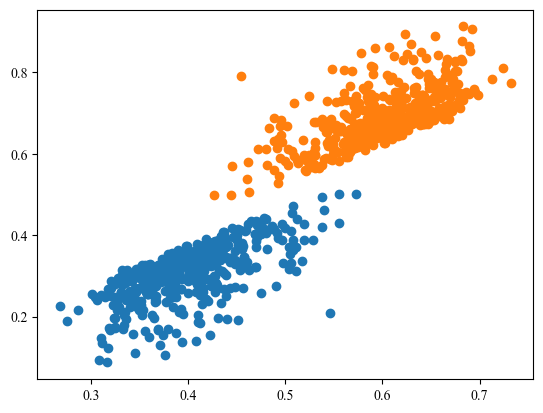

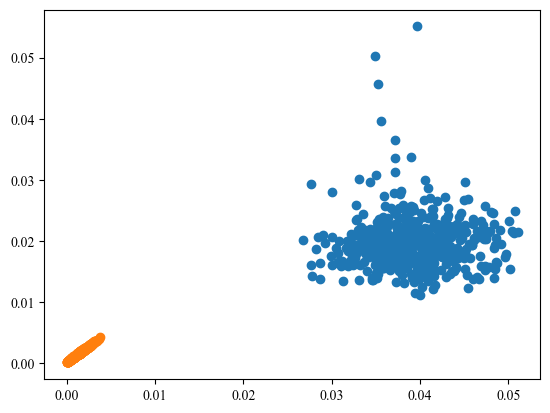

In [7]:

pl.scatter((np.array(TrueFracs)[:,0]+np.array(TrueFracs)[:,1]),np.array(FitFracs)[:,0],label= 'fast frac')

#pl.scatter(np.array(TrueFracs)[:,1],np.array(FitFracs)[:,1], label = 'med frac')
pl.scatter(np.array(TrueFracs)[:,2],np.array(FitFracs)[:,1], label = 'slow frac')
pl.show()

pl.scatter((np.array(TrueDiffs)[:,0]+np.array(TrueDiffs)[:,1])/2,np.array(FitDiffs)[:,0],label= 'fast diffs')
#pl.scatter(np.array(TrueDiffs)[:,1],np.array(FitDiffs)[:,1], label = 'med diffs')
pl.scatter(np.array(TrueDiffs)[:,2],np.array(FitDiffs)[:,1], label = 'slow diffs')
pl.show()


# now combined fD

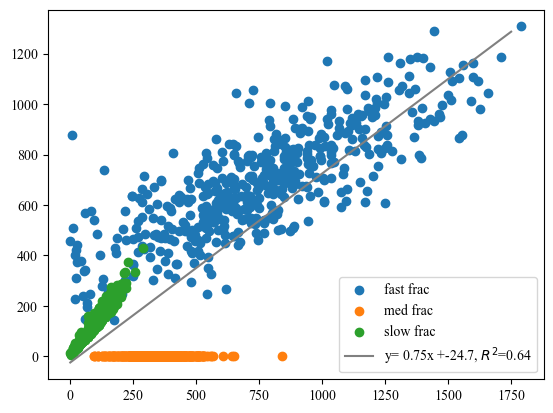

SignificanceResult(statistic=0.4204295198422623, pvalue=2.618268417157405e-65)
All fD difference = -124.38788 ± 213.86039, -199.66351%
fast fD mean difference = -0.57614± 2.03514, -7.93495%
med fD mean difference = -3.02504± 0.87361, -100.00000%
slow fD mean difference = 0.28417± 0.20042, 29.75486%


In [16]:
TruefastfDs= (1000*np.array(TrueFracs)[:,0]*np.array(TrueDiffs)[:,0]) #+ 1000*np.array(TrueFracs)[:,1]*np.array(TrueDiffs)[:,1])
FitfastfDs = 1000*np.array(FitFracs)[:,0]*np.array(FitDiffs)[:,0]

TruemedfDs= 1000*np.array(TrueFracs)[:,1]*np.array(TrueDiffs)[:,1]
FitmedfDs = 0*np.array(FitFracs)[:,0]*np.array(FitDiffs)[:,0]

TrueslowfDs= 1000*np.array(TrueFracs)[:,2]*np.array(TrueDiffs)[:,2]
FitslowfDs = 1000*np.array(FitFracs)[:,1]*np.array(FitDiffs)[:,1]

AllTrue = np.array(list(TruefastfDs)+list(TruemedfDs)+list(TrueslowfDs))
AllFit = np.array(list(FitfastfDs)+list(FitmedfDs)+list(FitslowfDs))

pl.scatter(112500*np.array(TrueFracs)[:,0]*np.array(TrueDiffs)[:,0], 112500*np.array(FitFracs)[:,0]*np.array(FitDiffs)[:,0],label= 'fast frac')
pl.scatter(112500*np.array(TrueFracs)[:,1]*np.array(TrueDiffs)[:,1], 0*np.array(FitFracs)[:,0]*np.array(FitDiffs)[:,0],label= 'med frac')
pl.scatter(112500*np.array(TrueFracs)[:,2]*np.array(TrueDiffs)[:,2], 112500*np.array(FitFracs)[:,1]*np.array(FitDiffs)[:,1],label= 'slow frac')

#pl.scatter(112.5*AllTrue,112.5*AllFit)
x = np.linspace(0,1750,100)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(112.5*AllTrue, 112.5*AllFit)
r_value2 = r_value**2
pl.plot(x,func(x,slope,intercept),label = f'y= {slope:.2f}x +{intercept: .1f}, $R^2$={r_value2:.2f}',color = 'grey') 
pl.legend()
pl.show()


print(scipy.stats.spearmanr(112.5*AllTrue, 112.5*AllFit))
print(f'All fD difference = {np.mean(112.5*AllFit - 112.5*AllTrue):.5f} ± {np.std(112.5*AllFit - 112.5*AllTrue):.5f}, {100*np.median((112.5*AllFit - 112.5*AllTrue)/112.5*AllTrue):.5f}%')
print(f'fast fD mean difference = {np.mean(FitfastfDs-TruefastfDs):.5f}± {np.std(FitfastfDs-TruefastfDs):.5f}, {100*np.median((FitfastfDs-TruefastfDs)/TruefastfDs):.5f}%')
print(f'med fD mean difference = {np.mean(FitmedfDs-TruemedfDs):.5f}± {np.std(FitmedfDs-TruemedfDs):.5f}, {100*np.median((FitmedfDs-TruemedfDs)/TruemedfDs):.5f}%')
print(f'slow fD mean difference = {np.mean(FitslowfDs-TrueslowfDs):.5f}± {np.std(FitslowfDs-TrueslowfDs):.5f}, {100*np.median((FitslowfDs-TrueslowfDs)/TrueslowfDs):.5f}%')


# fD and compared to just vascular

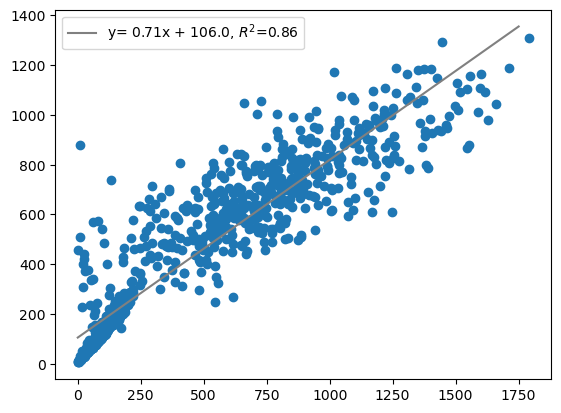

SignificanceResult(statistic=0.9425770745770746, pvalue=0.0)
All fD difference = -16.42330 ± 169.72271, 12.50154%
fast fD mean difference = -0.57614± 2.03514, -7.93495%
slow fD mean difference = 0.28417± 0.20042, 29.75486%


In [86]:
TruefastfDs= (1000*np.array(TrueFracs)[:,0]*np.array(TrueDiffs)[:,0]) #+ 1000*np.array(TrueFracs)[:,1]*np.array(TrueDiffs)[:,1])
FitfastfDs = 1000*np.array(FitFracs)[:,0]*np.array(FitDiffs)[:,0]

#TruemedfDs= 1000*np.array(TrueFracs)[:,1]*np.array(TrueDiffs)[:,1]
#FitmedfDs = 1000*np.array(FitFracs)[:,1]*np.array(FitDiffs)[:,1]

TrueslowfDs= 1000*np.array(TrueFracs)[:,2]*np.array(TrueDiffs)[:,2]
FitslowfDs = 1000*np.array(FitFracs)[:,1]*np.array(FitDiffs)[:,1]

AllTrue = np.append(TruefastfDs,TrueslowfDs)
AllFit = np.append(FitfastfDs,FitslowfDs)

pl.scatter(112.5*AllTrue,112.5*AllFit)
x = np.linspace(0,1750,100)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(112.5*AllTrue, 112.5*AllFit)
r_value2 = r_value**2
pl.plot(x,func(x,slope,intercept),label = f'y= {slope:.2f}x +{intercept: .1f}, $R^2$={r_value2:.2f}',color = 'grey') 
pl.legend()
pl.show()


print(scipy.stats.spearmanr(112.5*AllTrue, 112.5*AllFit))
print(f'All fD difference = {np.mean(112.5*AllFit - 112.5*AllTrue):.5f} ± {np.std(112.5*AllFit - 112.5*AllTrue):.5f}, {100*np.median((112.5*AllFit - 112.5*AllTrue)/112.5*AllTrue):.5f}%')
print(f'fast fD mean difference = {np.mean(FitfastfDs-TruefastfDs):.5f}± {np.std(FitfastfDs-TruefastfDs):.5f}, {100*np.median((FitfastfDs-TruefastfDs)/TruefastfDs):.5f}%')
#print(f'med fD mean difference = {np.mean(FitmedfDs-TruemedfDs):.5f}± {np.std(FitmedfDs-TruemedfDs):.5f}, {100*np.median((FitmedfDs-TruemedfDs)/TruemedfDs):.5f}%')
print(f'slow fD mean difference = {np.mean(FitslowfDs-TrueslowfDs):.5f}± {np.std(FitslowfDs-TrueslowfDs):.5f}, {100*np.median((FitslowfDs-TrueslowfDs)/TrueslowfDs):.5f}%')


# bi-exp fD and compared to just tubule

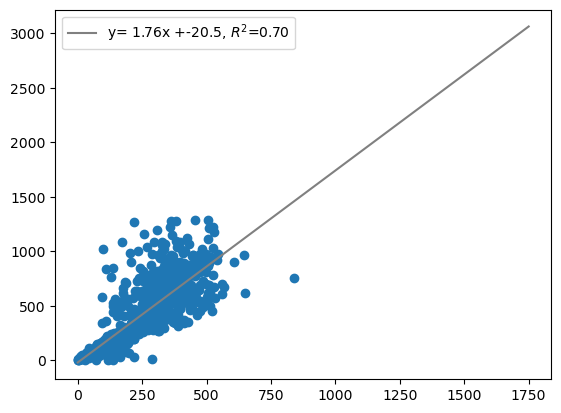

SignificanceResult(statistic=0.8946763026763028, pvalue=0.0)
All fD difference = 146.64299 ± 199.99538, 63.53164%
fast fD mean difference = 2.50967± 1.81732, 74.67780%
slow fD mean difference = 0.09732± 0.32912, 13.64754%


In [37]:
TruefastfDs= (1000*np.array(TrueFracs)[:,1]*np.array(TrueDiffs)[:,1])
FitfastfDs = 1000*np.array(FitFracs)[:,0]*np.array(FitDiffs)[:,0]

#TruemedfDs= 1000*np.array(TrueFracs)[:,1]*np.array(TrueDiffs)[:,1]
#FitmedfDs = 1000*np.array(FitFracs)[:,1]*np.array(FitDiffs)[:,1]

TrueslowfDs= 1000*np.array(TrueFracs)[:,2]*np.array(TrueDiffs)[:,2]
FitslowfDs = 1000*np.array(FitFracs)[:,1]*np.array(FitDiffs)[:,1]

AllTrue = np.append(TruefastfDs,TrueslowfDs)
AllFit = np.append(FitfastfDs,FitslowfDs)

pl.scatter(112.5*AllTrue,112.5*AllFit)
x = np.linspace(0,1750,100)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(112.5*AllTrue, 112.5*AllFit)
r_value2 = r_value**2
pl.plot(x,func(x,slope,intercept),label = f'y= {slope:.2f}x +{intercept: .1f}, $R^2$={r_value2:.2f}',color = 'grey') 
pl.legend()
pl.show()


print(scipy.stats.spearmanr(112.5*AllTrue, 112.5*AllFit))
print(f'All fD difference = {np.mean(112.5*AllFit - 112.5*AllTrue):.5f} ± {np.std(112.5*AllFit - 112.5*AllTrue):.5f}, {100*np.median((112.5*AllFit - 112.5*AllTrue)/112.5*AllTrue):.5f}%')
print(f'fast fD mean difference = {np.mean(FitfastfDs-TruefastfDs):.5f}± {np.std(FitfastfDs-TruefastfDs):.5f}, {100*np.median((FitfastfDs-TruefastfDs)/TruefastfDs):.5f}%')
#print(f'med fD mean difference = {np.mean(FitmedfDs-TruemedfDs):.5f}± {np.std(FitmedfDs-TruemedfDs):.5f}, {100*np.median((FitmedfDs-TruemedfDs)/TruemedfDs):.5f}%')
print(f'slow fD mean difference = {np.mean(FitslowfDs-TrueslowfDs):.5f}± {np.std(FitslowfDs-TrueslowfDs):.5f}, {100*np.median((FitslowfDs-TrueslowfDs)/TrueslowfDs):.5f}%')
